<a href="https://colab.research.google.com/github/lNamelessl/ML-Projects/blob/main/House_Prices_Prediction_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the dependencies
import json
import os
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
# loading kaggle credentials
kaggle_credentials = json.load(open('/content/drive/MyDrive/kaggle.json'))


In [ ]:
# set up api credentials as env vars
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [ ]:
! kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 78.8MB/s]


In [ ]:
# extracting the datasets
with ZipFile('/content/house-prices-advanced-regression-techniques.zip', 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Removing Outliers**

In [ ]:
outliers = []
def add_outliers(ids):
  for id in ids:
    if not id in outliers:
      outliers.append(id)

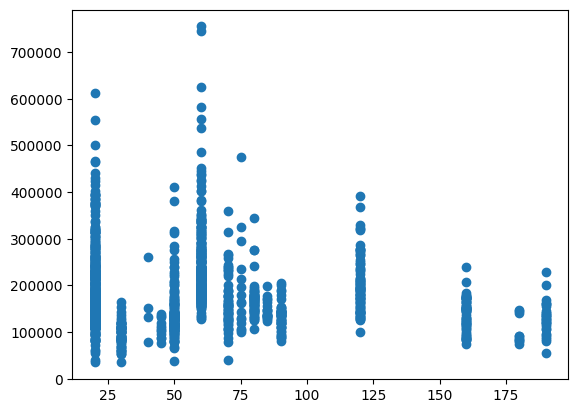

In [ ]:
plt.scatter(x='MSSubClass', y='SalePrice', data=train_df)

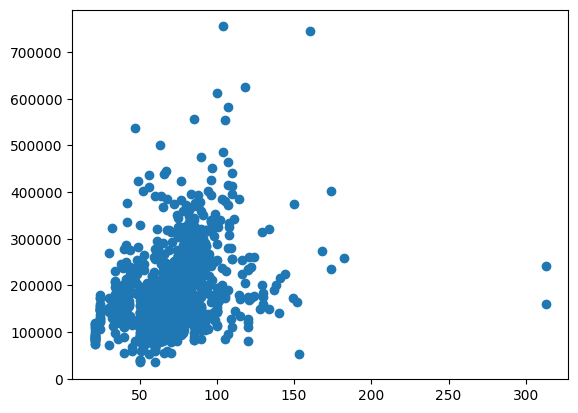

In [ ]:
plt.scatter(x='LotFrontage', y='SalePrice', data=train_df)

In [ ]:
train_df.query('LotFrontage > 300')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [ ]:
add_outliers(ids=[935, 1299])


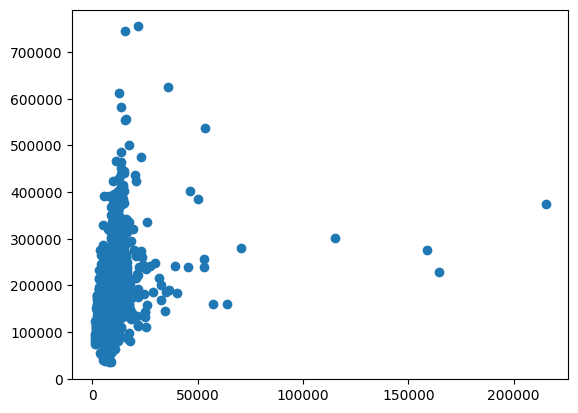

In [ ]:
plt.scatter(x='LotArea', y='SalePrice', data=train_df)

In [ ]:
train_df.query('LotArea  > 60000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [ ]:
stats.zscore(train_df['LotArea']).sort_values().tail(10)

,LotArea
384,4.268474
457,4.280500
769,4.308262
1396,4.678682
1298,5.348867
451,6.037793
706,10.486449
249,14.881285
335,15.448542
313,20.518273


In [ ]:
add_outliers(ids=[452, 707, 250, 336, 314])

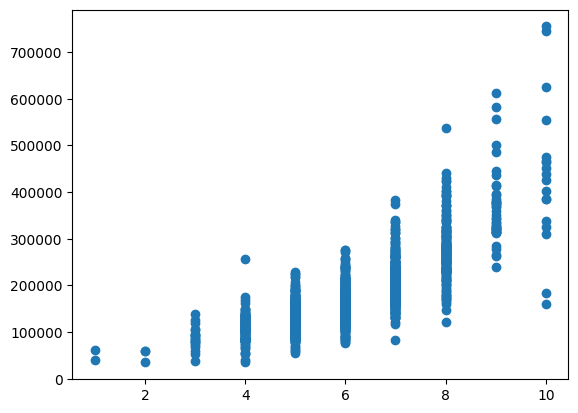

In [ ]:
plt.scatter(x='OverallQual', y='SalePrice', data=train_df)

In [ ]:
train_df.query('OverallQual == 10 & SalePrice < 200000 ')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


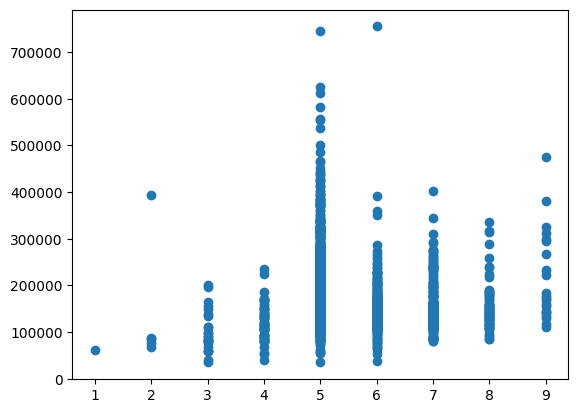

In [ ]:
plt.scatter(x='OverallCond', y='SalePrice', data=train_df)

In [ ]:
train_df.query('OverallCond == 2 & SalePrice > 300000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
378,379,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432


In [ ]:
add_outliers(ids=[379])

In [ ]:
train_df.query('OverallCond == 5 & SalePrice > 700000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [ ]:
add_outliers(ids=[1183])

In [ ]:
train_df.query('OverallCond == 6 & SalePrice > 700000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


In [ ]:
add_outliers(ids=[692])

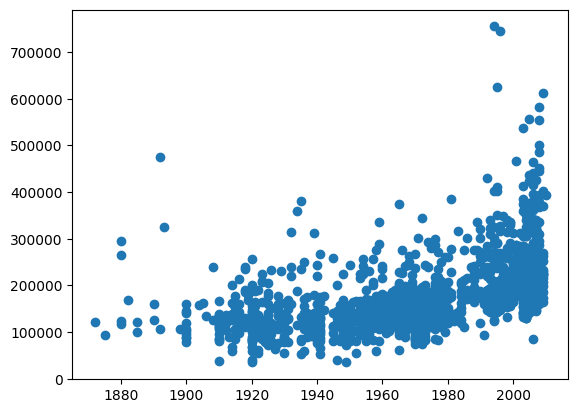

In [ ]:
plt.scatter(x='YearBuilt', y='SalePrice', data=train_df)

In [ ]:
train_df.query('YearBuilt  < 1900 & SalePrice > 400000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


In [ ]:
add_outliers(ids=[186])

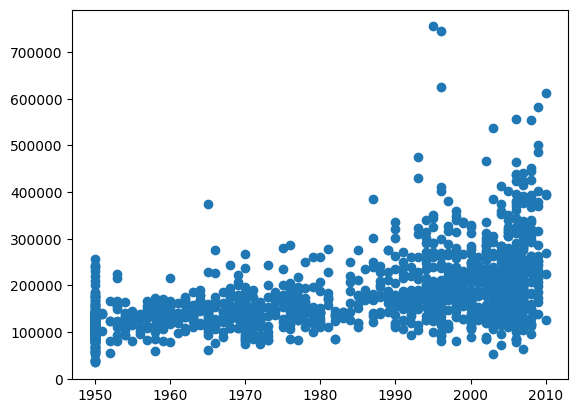

In [ ]:
plt.scatter(x='YearRemodAdd', y='SalePrice', data=train_df)

In [ ]:
train_df.query('YearRemodAdd < 1970& SalePrice > 300000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


In [ ]:
add_outliers(ids=[314])

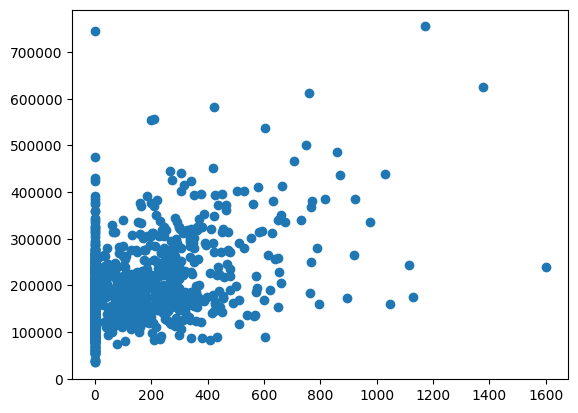

In [ ]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=train_df)

In [ ]:
train_df.query('MasVnrArea > 1500 ')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


In [ ]:
add_outliers(ids=[298])

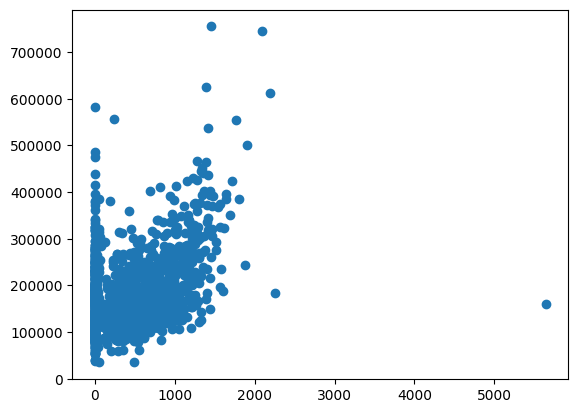

In [ ]:
plt.scatter(x='BsmtFinSF1', y='SalePrice', data=train_df)

In [ ]:
train_df.query('BsmtFinSF1 > 5000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [ ]:
add_outliers(ids=[1299])

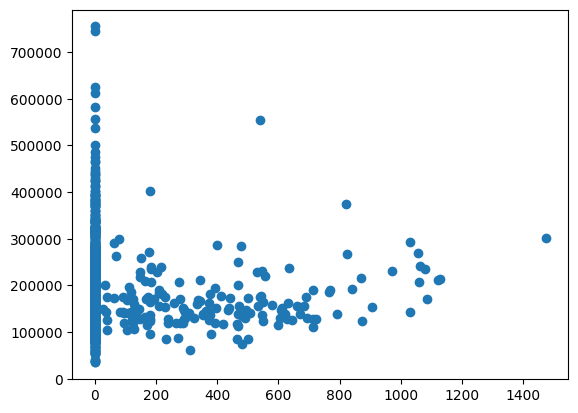

In [ ]:
plt.scatter(x='BsmtFinSF2', y='SalePrice', data=train_df)

In [ ]:
train_df.query('BsmtFinSF2 > 400 & SalePrice > 500000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


In [ ]:
add_outliers(ids=[441])

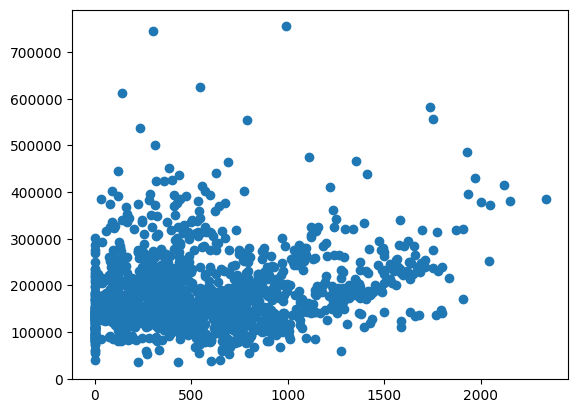

In [ ]:
plt.scatter(x='BsmtUnfSF', y='SalePrice', data=train_df)

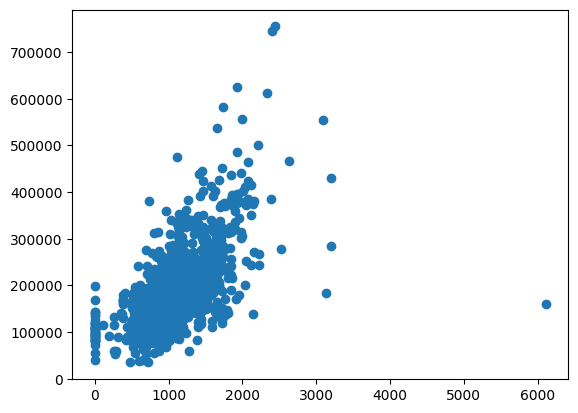

In [ ]:
plt.scatter(x='TotalBsmtSF', y='SalePrice', data=train_df )

In [ ]:
train_df.query('TotalBsmtSF > 5000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


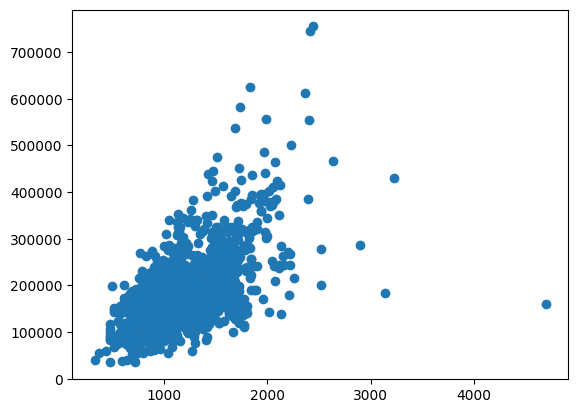

In [ ]:
plt.scatter(x='1stFlrSF', y='SalePrice', data=train_df)

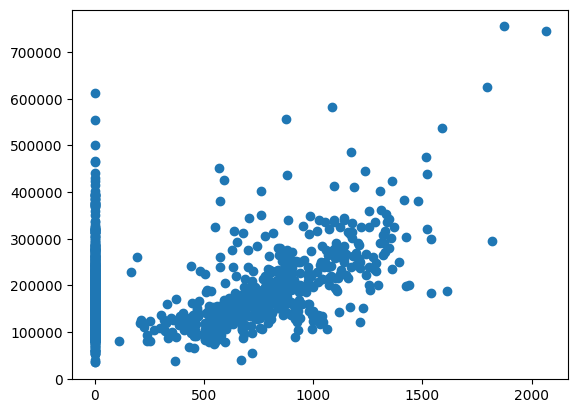

In [ ]:
plt.scatter(x='2ndFlrSF', y='SalePrice', data=train_df)

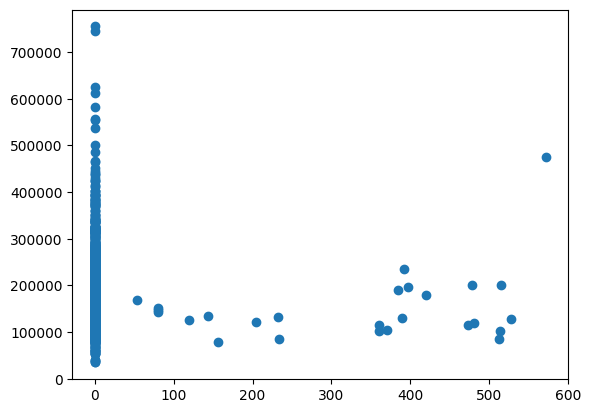

In [ ]:
plt.scatter(x='LowQualFinSF', y='SalePrice', data=train_df)

In [ ]:
train_df.query('LowQualFinSF > 550')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


In [ ]:
add_outliers(ids=[186])

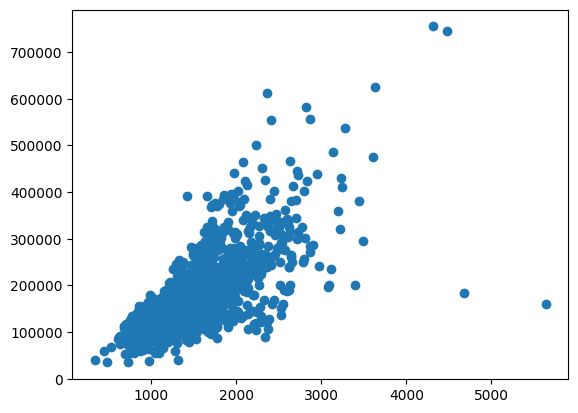

In [ ]:
plt.scatter(x='GrLivArea', y='SalePrice', data=train_df)

In [ ]:
train_df.query('GrLivArea > 4500')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [ ]:
add_outliers(ids=[523])

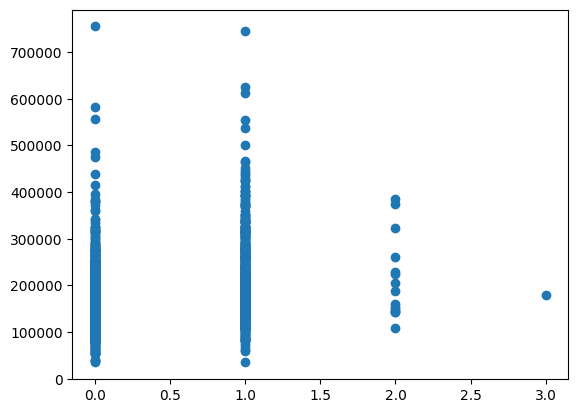

In [ ]:
plt.scatter(x='BsmtFullBath', y='SalePrice', data=train_df)

In [ ]:
train_df.query('BsmtFullBath == 3')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
738,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000


In [ ]:
add_outliers(ids=[739])

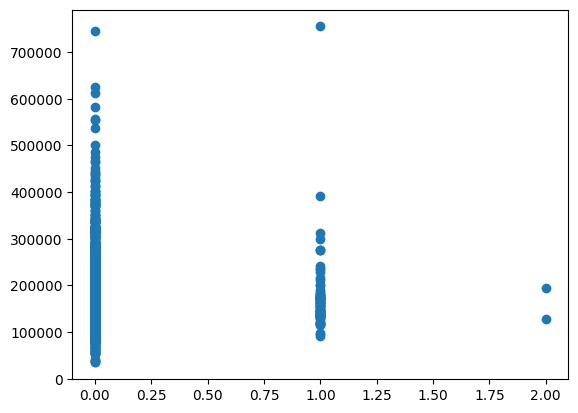

In [ ]:
plt.scatter(x='BsmtHalfBath', y='SalePrice', data=train_df)

In [ ]:
stats.zscore(train_df['BsmtHalfBath']).unique()

array([-0.24106104,  3.94880935,  8.13867973])

In [ ]:
train_df.query('BsmtHalfBath == 2')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
597,598,120,RL,53.0,3922,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2007,New,Partial,194201
954,955,90,RL,35.0,9400,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,AdjLand,127500


In [ ]:
add_outliers(ids=[598, 955])

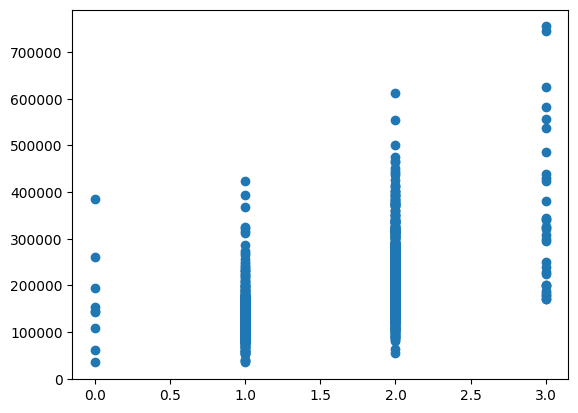

In [ ]:
plt.scatter(x='FullBath', y='SalePrice', data=train_df)

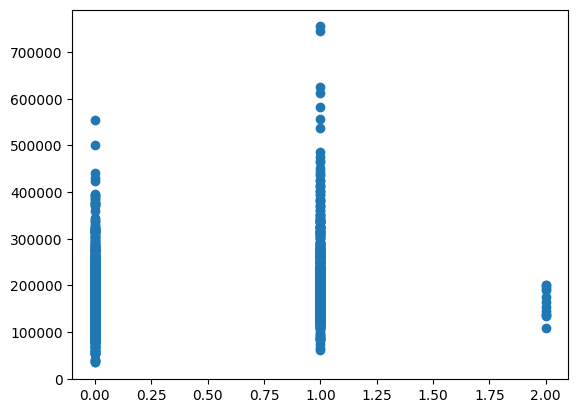

In [ ]:
plt.scatter(x='HalfBath', y='SalePrice', data=train_df)

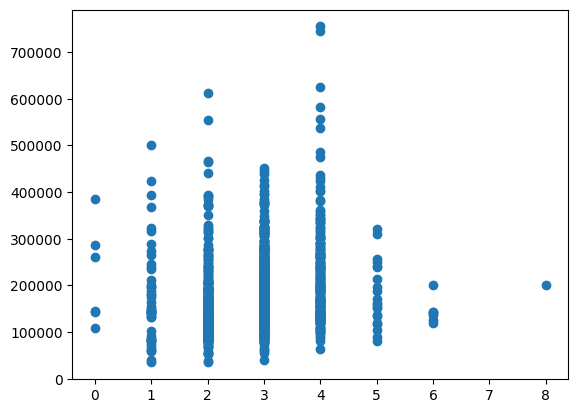

In [ ]:
plt.scatter(x='BedroomAbvGr', y='SalePrice', data=train_df)

In [ ]:
train_df.query('BedroomAbvGr == 8')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


In [ ]:
add_outliers(ids=[636])

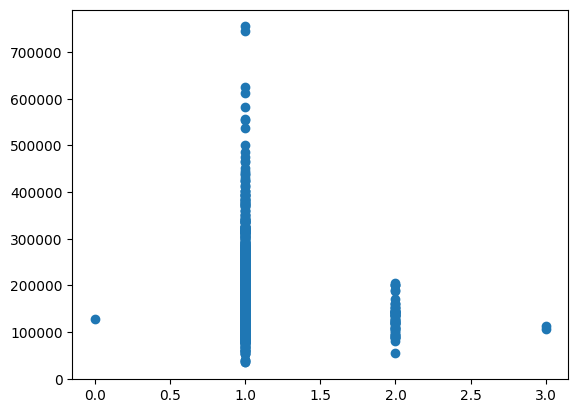

In [ ]:
plt.scatter(x='KitchenAbvGr', y='SalePrice', data=train_df)

In [ ]:
train_df.query('KitchenAbvGr == 3')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
809,810,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000


In [ ]:
add_outliers(ids=[810])

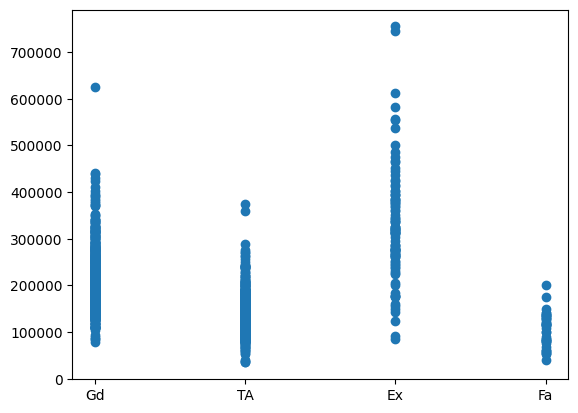

In [ ]:
plt.scatter(x='KitchenQual', y='SalePrice', data=train_df)

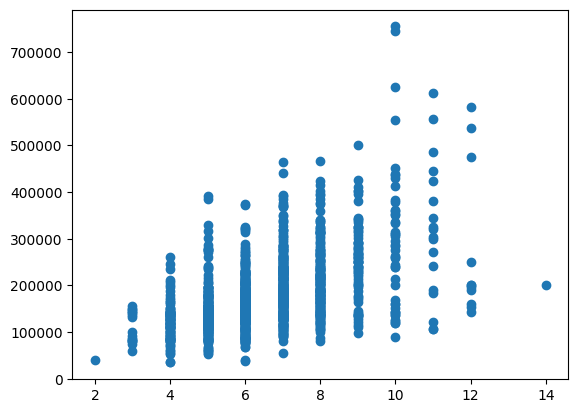

In [ ]:
plt.scatter(x='TotRmsAbvGrd', y='SalePrice', data=train_df)

In [ ]:
train_df.query('TotRmsAbvGrd == 14')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


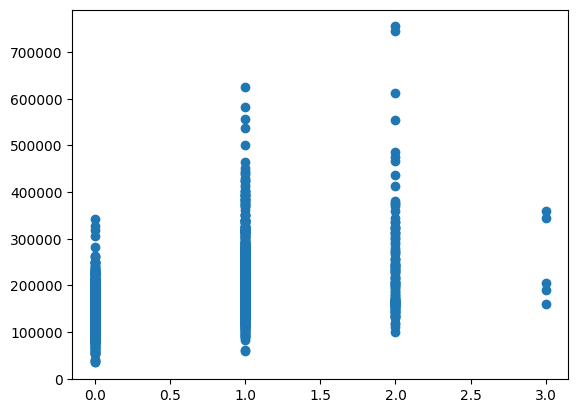

In [ ]:
plt.scatter(x='Fireplaces', y='SalePrice', data=train_df)

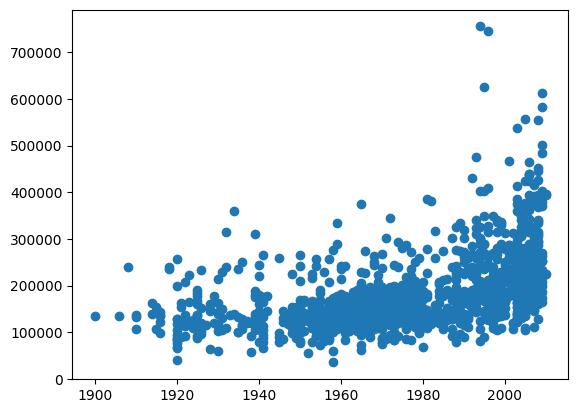

In [ ]:
plt.scatter(x='GarageYrBlt', y='SalePrice', data=train_df)

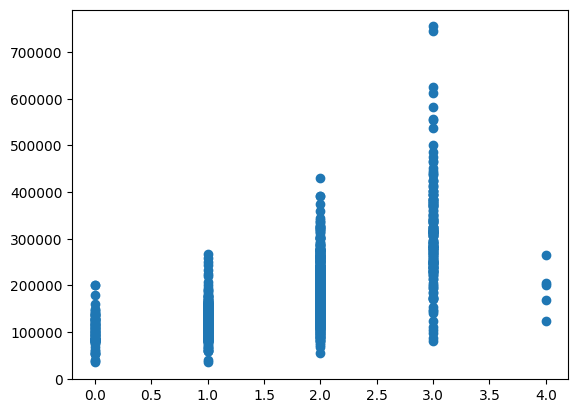

In [ ]:
plt.scatter(x='GarageCars', y='SalePrice', data=train_df)

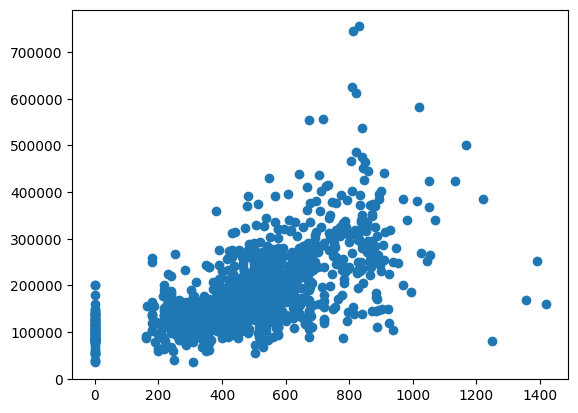

In [ ]:
plt.scatter(x='GarageArea', y='SalePrice', data=train_df)

In [ ]:
train_df.query('GarageArea > 1200')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,582,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
825,826,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
1061,1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [ ]:
add_outliers(ids=[1062, 1191])


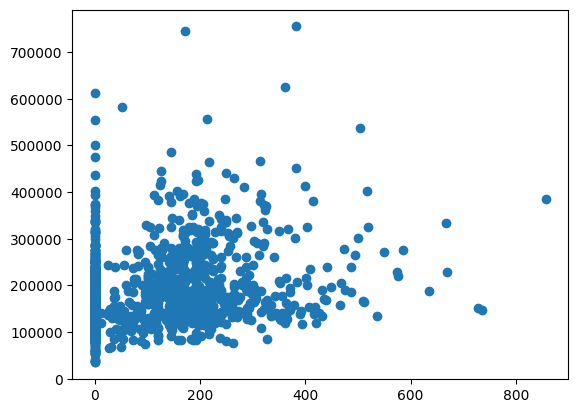

In [ ]:
plt.scatter(x='WoodDeckSF', y='SalePrice', data=train_df)

In [ ]:
train_df.query('WoodDeckSF > 750')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
53,54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000


In [ ]:
add_outliers(ids=[54])

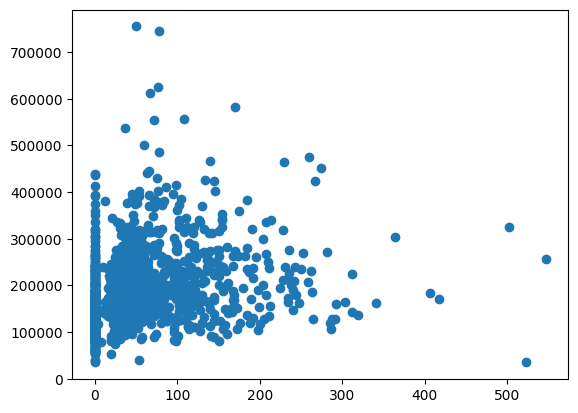

In [ ]:
plt.scatter(x='OpenPorchSF', y='SalePrice', data=train_df)

In [ ]:
train_df.query('OpenPorchSF > 500')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
1328,1329,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,1150,6,2008,WD,Normal,256000


In [ ]:
add_outliers(ids=[496])

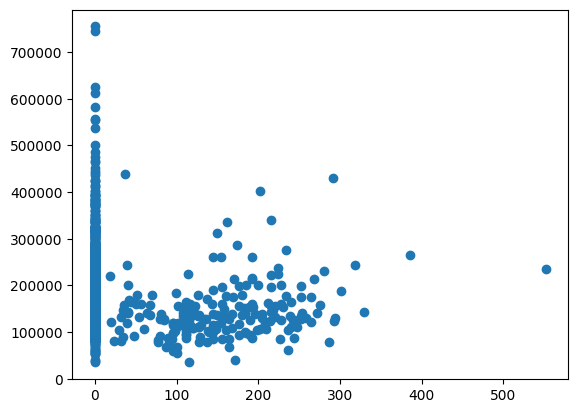

In [ ]:
plt.scatter(x='EnclosedPorch', y='SalePrice', data=train_df)

In [ ]:
train_df.query('EnclosedPorch > 500')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000


In [ ]:
add_outliers(ids=[198])

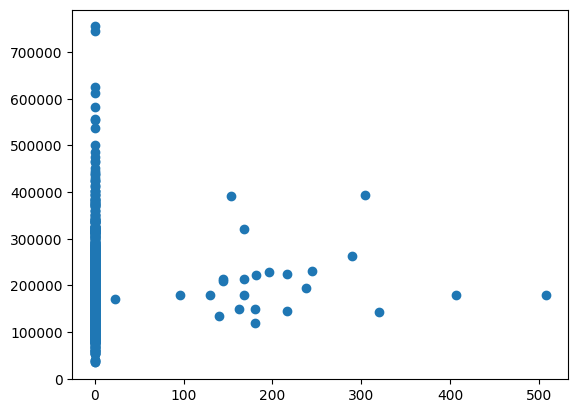

In [ ]:
plt.scatter(x='3SsnPorch', y='SalePrice', data=train_df)

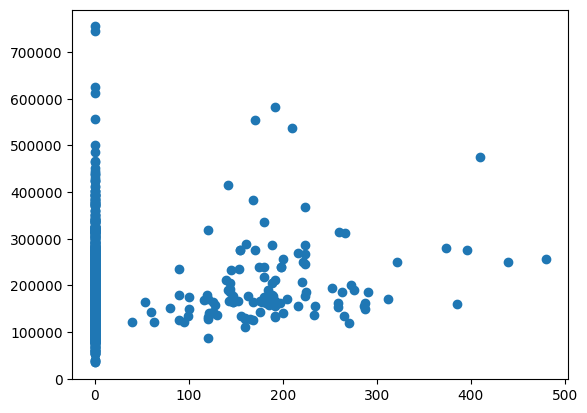

In [ ]:
plt.scatter(x='ScreenPorch', y='SalePrice', data=train_df)

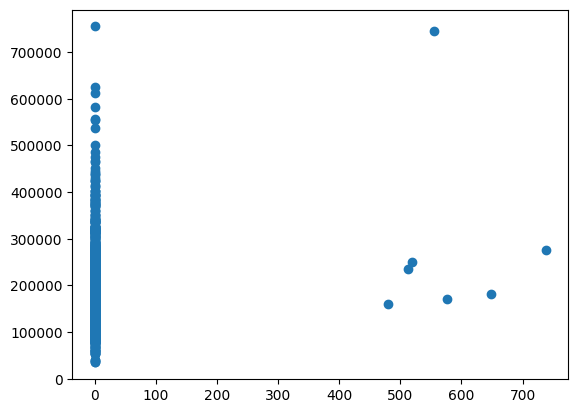

In [ ]:
plt.scatter(x='PoolArea', y='SalePrice', data=train_df)

In [ ]:
len(outliers)

24

In [ ]:
train_df = train_df[train_df.Id.isin(outliers) == False]

In [ ]:
train_df.isnull().sum().sort_values(ascending=False).head(20)

,0
PoolQC,1432
MiscFeature,1385
Alley,1347
Fence,1160
MasVnrType,858
FireplaceQu,684
LotFrontage,255
GarageYrBlt,77
GarageCond,77
GarageType,77


In [ ]:
train_df['Alley'].fillna('No', inplace=True)
test_df['Alley'].fillna('No', inplace=True)

<ipython-input-93-b441ac6b2592>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Alley'].fillna('No', inplace=True)


In [ ]:
train_df['Fence'].fillna('No', inplace=True)
test_df['Fence'].fillna('No', inplace=True)

<ipython-input-94-487fd39674d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Fence'].fillna('No', inplace=True)


In [ ]:
train_df['MasVnrType'].fillna('No', inplace=True)
test_df['MasVnrType'].fillna('No', inplace=True)

<ipython-input-95-6613c27331c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['MasVnrType'].fillna('No', inplace=True)


In [ ]:
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

<ipython-input-96-75a3ef65fa78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['MasVnrArea'].fillna(0, inplace=True)


In [ ]:
train_df['FireplaceQu'].fillna('No', inplace=True)
test_df['FireplaceQu'].fillna('No', inplace=True)

<ipython-input-97-e7aa724f0c3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['FireplaceQu'].fillna('No', inplace=True)


In [ ]:
train_df['LotFrontage'].fillna(0, inplace=True)
test_df['LotFrontage'].fillna(0, inplace=True)

<ipython-input-98-1323975fd6c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['LotFrontage'].fillna(0, inplace=True)


In [ ]:
train_df['GarageCond'].fillna('No', inplace=True)
test_df['GarageCond'].fillna('No', inplace=True)

<ipython-input-99-0e0907867bf3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['GarageCond'].fillna('No', inplace=True)


In [ ]:
train_df['GarageType'].fillna('No', inplace=True)
test_df['GarageType'].fillna('No', inplace=True)

In [ ]:
train_df['GarageFinish'].fillna('No', inplace=True)
test_df['GarageFinish'].fillna('No', inplace=True)

In [ ]:
train_df['GarageQual'].fillna('No', inplace=True)
test_df['GarageQual'].fillna('No', inplace=True)

In [ ]:
train_df['BsmtFinType2'].fillna('Unf', inplace=True)
test_df['BsmtFinType2'].fillna('Unf', inplace=True)

In [ ]:
train_df['BsmtExposure'].fillna('No', inplace=True)
test_df['BsmtExposure'].fillna('No', inplace=True)

In [ ]:
train_df['BsmtQual'].fillna('No', inplace=True)
test_df['BsmtQual'].fillna('No', inplace=True)

In [ ]:
train_df['BsmtCond'].fillna('No', inplace=True)
test_df['BsmtCond'].fillna('No', inplace=True)

In [ ]:
train_df['BsmtFinType1'].fillna('Unf', inplace=True)
test_df['BsmtFinType1'].fillna('Unf', inplace=True)

In [ ]:
train_df['Electrical'].fillna('SBrkr', inplace=True)
test_df['Electrical'].fillna('SBrkr', inplace=True)

In [ ]:
train_df = train_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])

In [ ]:
train_df.isnull().sum().sort_values(ascending=False).head(20)

,0
Id,0
FireplaceQu,0
Functional,0
TotRmsAbvGrd,0
KitchenQual,0
KitchenAbvGr,0
BedroomAbvGr,0
HalfBath,0
FullBath,0
BsmtHalfBath,0


In [ ]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


Feature engineering

In [ ]:
train_df['houseage'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['houseage'] = test_df['YrSold'] - test_df['YearBuilt']

In [ ]:
train_df['remodelage'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['remodelage'] = test_df['YrSold'] - test_df['YearRemodAdd']

In [ ]:
train_df['totalSF'] = train_df['BsmtFinSF1'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['totalSF'] = test_df['BsmtFinSF1'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

In [ ]:
train_df['totalarea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']
test_df['totalarea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']

In [ ]:
train_df['totalbath'] =  train_df['FullBath'] + train_df['BsmtFullBath'] + 0.5 * (train_df['BsmtHalfBath'] + train_df['HalfBath'])
test_df['totalbath'] =  test_df['FullBath'] + test_df['BsmtFullBath'] + 0.5 * (test_df['BsmtHalfBath'] + test_df['HalfBath'])

In [ ]:
train_df['totalporchsf'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['3SsnPorch'] + train_df['ScreenPorch'] + train_df['WoodDeckSF']
test_df['totalporchsf'] = test_df['OpenPorchSF'] + test_df['EnclosedPorch'] + test_df['3SsnPorch'] + test_df['ScreenPorch'] + test_df['WoodDeckSF']

In [ ]:
train_df = train_df.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF', 'GarageArea'])
test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF', 'GarageArea'])

<Axes: >

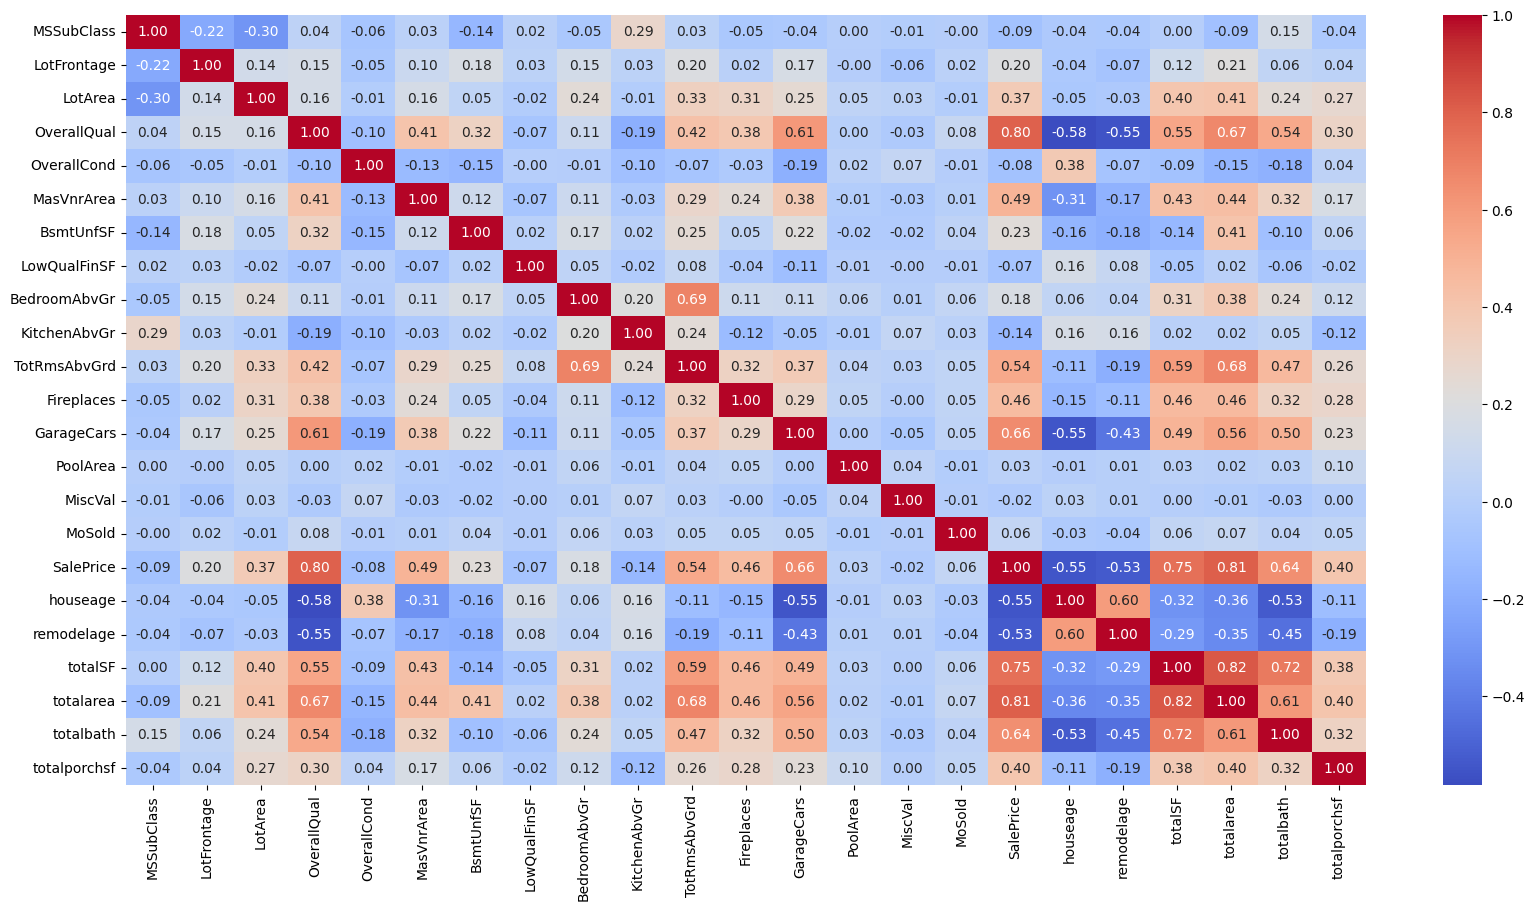

In [ ]:
correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

<Axes: xlabel='SalePrice', ylabel='Count'>

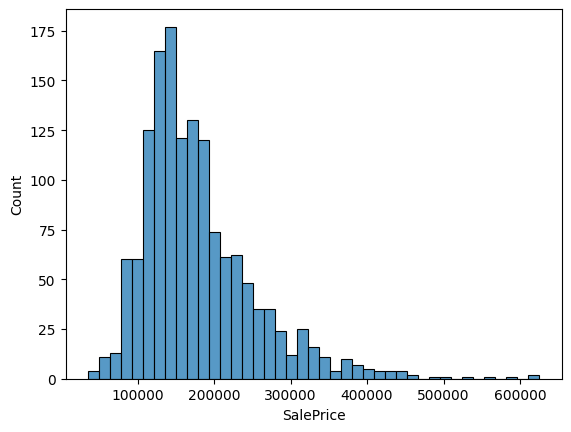

In [ ]:
sns.histplot(train_df, x=train_df['SalePrice'])

In [ ]:
train_df['SalePrice']  = np.log1p(train_df['SalePrice'])

<Axes: xlabel='SalePrice', ylabel='Count'>

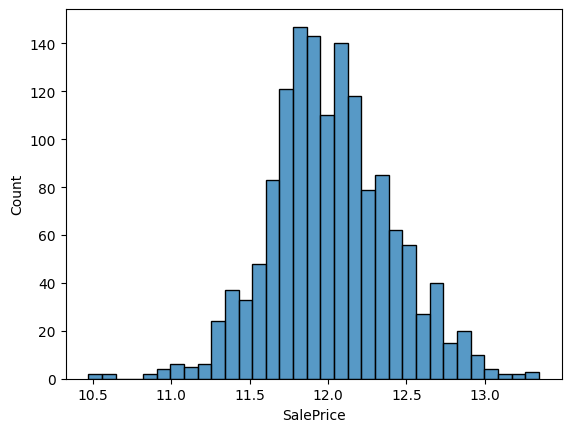

In [ ]:
sns.histplot(train_df, x=train_df['SalePrice'])

In [ ]:
train_df.dtypes[train_df.dtypes=="object"]

,0
MSZoning,object
Street,object
LotShape,object
LandContour,object
Utilities,object
LotConfig,object
LandSlope,object
Neighborhood,object
Condition1,object
Condition2,object


In [ ]:
train_df.dtypes[train_df.dtypes!="object"]

,0
MSSubClass,int64
LotFrontage,float64
LotArea,int64
OverallQual,int64
OverallCond,int64
MasVnrArea,float64
BsmtUnfSF,int64
LowQualFinSF,int64
BedroomAbvGr,int64
KitchenAbvGr,int64


In [ ]:
ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

In [ ]:
ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [ ]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

In [ ]:
num_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

In [ ]:
ode_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

In [ ]:
ohe_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [ ]:
col_trans = ColumnTransformer(transformers=[('num_p', num_pipeline, num_cols),('ode_p', ode_pipeline, ode_cols), ('ohe_p', ohe_pipeline, ohe_cols)], remainder='passthrough', n_jobs=-1 )

In [ ]:
pipeline = Pipeline(steps=[('preprocessing', col_trans)])

In [ ]:
X = train_df.drop('SalePrice', axis=1)
Y = train_df['SalePrice']

In [ ]:
X_preprocessed = pipeline.fit_transform(X)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_preprocessed, Y, test_size=0.2, random_state=25 )

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_pred_lr = lr.predict(x_test)

In [ ]:
mean_squared_error(y_test, y_pred_lr)

1.753322096677445e+16

In [ ]:
RFR = RandomForestRegressor(random_state=13)

In [ ]:
param_grid_RFR = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [ ]:
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
rfr_cv.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=13), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_mean_squared_error')

In [ ]:
np.sqrt(-1 * rfr_cv.best_score_)

0.13750684528195908

In [ ]:
XGB = XGBRegressor(random_state=13)

In [ ]:
param_grid_xgb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [ ]:
xgb_cv = GridSearchCV(XGB, param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
xgb_cv.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=13, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [ ]:
np.sqrt(-1 * xgb_cv.best_score_)

0.12377830591951215

In [ ]:
ridge = Ridge()

In [ ]:
param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

In [ ]:
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
ridge_cv.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag']},
             scoring='neg_mean_squared_error')

In [ ]:
np.sqrt(-1 * ridge_cv.best_score_)

0.12515742925467804

In [ ]:
GBR = GradientBoostingRegressor()

In [ ]:
param_grid_GBR = {
    'max_depth': [12, 15, 20],
    'n_estimators': [200, 300, 1000],
    'min_samples_leaf': [10, 25, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_features': [0.01, 0.1, 0.7]
}

In [ ]:
GBR_cv = GridSearchCV(GBR, param_grid_GBR, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
GBR_cv.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [12, 15, 20],
                         'max_features': [0.01, 0.1, 0.7],
                         'min_samples_leaf': [10, 25, 50],
                         'n_estimators': [200, 300, 1000]},
             scoring='neg_mean_squared_error')

In [ ]:
np.sqrt(-1 * GBR_cv.best_score_)

0.12085599888289705

In [ ]:
lgbm_regressor = LGBMRegressor()

In [ ]:
param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

In [ ]:
lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
lgbm_cv.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 1148, number of used features: 115
[LightGBM] [Info] Start training from score 12.020329


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [20, 30, 40]},
             scoring='neg_mean_squared_error')

In [ ]:
np.sqrt(-1 * lgbm_cv.best_score_)

0.13073823240032678

In [ ]:
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)

In [ ]:
param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

In [ ]:
cat_cv = GridSearchCV(catboost, param_grid_cat, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
cat_cv.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7c42b73c9ff0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5]},
             scoring='neg_mean_squared_error')

In [ ]:
np.sqrt(-1 * cat_cv.best_score_)

0.1208577981086952

In [ ]:
vr = VotingRegressor([('gbr', GBR_cv.best_estimator_),
                      ('xgb', xgb_cv.best_estimator_),
                      ('ridge', ridge_cv.best_estimator_)],
                    weights=[2,3,1])

In [ ]:
vr.fit(x_train, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=15,
                                                       max_features=0.1,
                                                       min_samples_leaf=25,
                                                       n_estimators=1000)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_m...
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None, min_child_weight=2,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=13, ...)),
                            ('ridge', Ridge(alpha=10))],
                weights=[2, 3, 1])

In [ ]:
y_pred_vr = vr.predict(x_test)

In [ ]:
mean_squared_error(y_test, y_pred_vr, squared=False)

0.11864068542364489

In [ ]:
estimators = [
    ('gbr', GBR_cv.best_estimator_),
    ('xgb', xgb_cv.best_estimator_),
    ('cat', cat_cv.best_estimator_),
    ('lgb', lgbm_cv.best_estimator_),
    ('rfr', rfr_cv.best_estimator_),
]

In [ ]:
stackreg = StackingRegressor(
            estimators = estimators,
            final_estimator = vr
)

In [ ]:
stackreg.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 1148, number of used features: 115
[LightGBM] [Info] Start training from score 12.020329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 918, number of used features: 106
[LightGBM] [Info] Start training from score 12.014625
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=15,
                                                         max_features=0.1,
                                                         min_samples_leaf=25,
                                                         n_estimators=1000)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval...
                                                                            importance_type=None,
                                                                            interaction_constraints=None,
                                                                            learning_rate=0.1,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=3,
                                                                            max_leaves=None,
                                                                            min_child_weight=2,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=300,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=13, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=10))],
                                                  weights=[2, 3, 1]))

In [ ]:
y_pred_stack = stackreg.predict(x_test)

In [ ]:
mean_squared_error(y_test, y_pred_stack, squared=False)

0.12458583327215983

In [ ]:
df_test_preprocess = pipeline.transform(test_df)

In [ ]:
y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_df[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('submission.csv', index=False)

<ipython-input-204-b9faf63539ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['SalePrice'] = y_stacking
